
# Tomography Segmentation Lab (scikit-image)

**Goal:** Starting from a reconstructed tomographic volume (e.g., 1017 axial slices), evaluate classical *unsupervised* segmentation methods in `scikit-image` (Otsu, Li, Triangle, Watershed), clean up artifacts, and curate a small set of high‑quality masks that will be used later to train a deep learning model.

**What you'll do:**  
1) Load a stack of slices and inspect intensity distributions.  
2) Try thresholding (Otsu, Li, Triangle) and compare segmentations quantitatively.  
3) Try Watershed with marker selection (distance transform + h-minima).  
4) Remove small speckles using morphology / connected components.  
5) Select a small subset of slices and **manually refine** masks where needed (lightweight curation).  
6) Save curated masks to a `gold_masks/` folder for future model training.



## 1) Setup & data loading

- Point `DATA_DIR` to the folder with your reconstructed slices.  
- Supported formats: TIFF, PNG, JPEG (TIFF preferred).  
- If memory is limited, you can work on a subset of indices and then switch to the full volume.


Found 10 slices
Stack shape: (10, 1100, 1100) dtype: float64


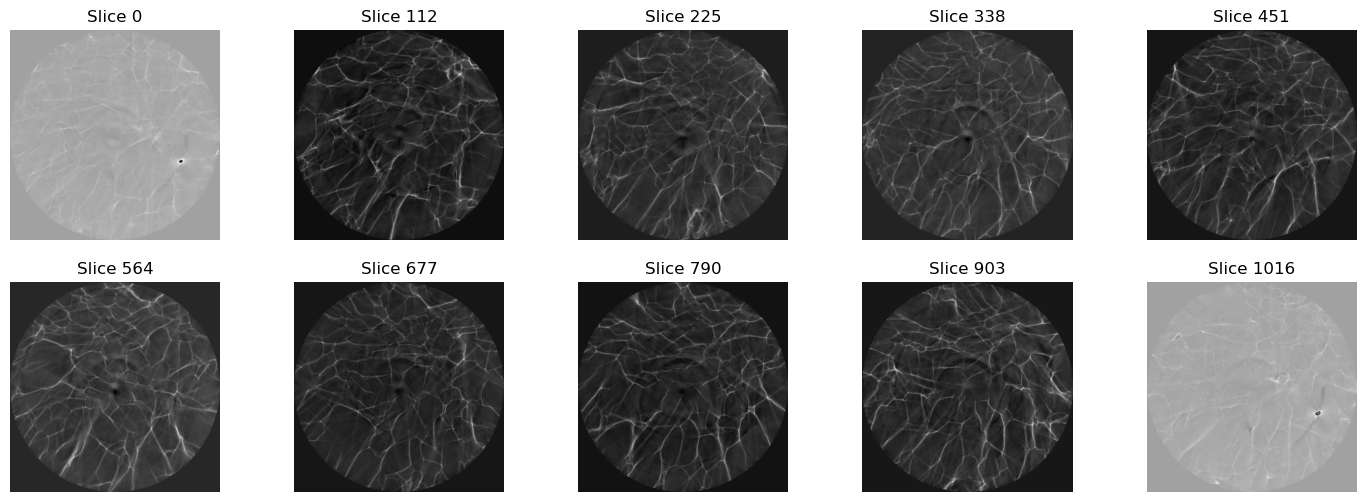

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, filters, morphology, measure, exposure, segmentation, feature, util
from skimage.filters import threshold_otsu, threshold_li, threshold_triangle, rank
from scipy import ndimage as ndi

# ---- CONFIG ----
DATA_DIR = Path("/mnt/bgfs/projects/tomo_nano/joana/data/recon_phase_int")  # <-- TODO: set this
PATTERN = "*.tiff"                        # e.g., '*.tif' or '*.png'
READ_AS_FLOAT = True                     # convert to float in [0, 1]

#Optional: restrict to a subset for quicker iteration (e.g., every 5th slice)
STRIDE = 1      # use 1 for all slices
MAX_SLICES = 10  # e.g., 200 for quick tests, or None to read all

# ---- Load file list ----
files = sorted(DATA_DIR.glob(PATTERN)) #lista de caminhos para cada imagem
n = len(files)
## if MAX_SLICES is not None:
#     files = files
#files = files[::STRIDE]

indices = np.linspace(0, n - 1, MAX_SLICES, dtype=int)
files = [files[i] for i in indices]

print(f"Found {len(files)} slices")

# ---- Load stack ----
if len(files) == 0:
    raise FileNotFoundError("No files found. Check DATA_DIR and PATTERN.")

stack = io.imread_collection([str(f) for f in files]).concatenate() #resgata as imagens pelo caminho
if READ_AS_FLOAT:
    stack = util.img_as_float(stack)

print("Stack shape:", stack.shape, "dtype:", stack.dtype)

    # Quick peek
#mid = stack.shape[0] // 2
fig, axes = plt.subplots(2,5, figsize=(18,6))
fig.subplots_adjust(wspace=0.1, hspace=0.2)
axes[0,0].imshow(stack[0], cmap="gray"); axes[0,0].axis("off") ; axes[0,0].set_title(f"Slice {indices[0]}")
axes[0,1].imshow(stack[1], cmap="gray"); axes[0,1].axis("off") ; axes[0,1].set_title(f"Slice {indices[1]}")
axes[0,2].imshow(stack[2], cmap="gray"); axes[0,2].axis("off") ; axes[0,2].set_title(f"Slice {indices[2]}")
axes[0,3].imshow(stack[3], cmap="gray"); axes[0,3].axis("off") ; axes[0,3].set_title(f"Slice {indices[3]}")
axes[0,4].imshow(stack[4], cmap="gray"); axes[0,4].axis("off") ; axes[0,4].set_title(f"Slice {indices[4]}")
axes[1,0].imshow(stack[5], cmap="gray"); axes[1,0].axis("off") ; axes[1,0].set_title(f"Slice {indices[5]}")
axes[1,1].imshow(stack[6], cmap="gray"); axes[1,1].axis("off") ; axes[1,1].set_title(f"Slice {indices[6]}")
axes[1,2].imshow(stack[7], cmap="gray"); axes[1,2].axis("off") ; axes[1,2].set_title(f"Slice {indices[7]}")
axes[1,3].imshow(stack[8], cmap="gray"); axes[1,3].axis("off") ; axes[1,3].set_title(f"Slice {indices[8]}")
axes[1,4].imshow(stack[9], cmap="gray"); axes[1,4].axis("off") ; axes[1,4].set_title(f"Slice {indices[9]}")
plt.show()


## 2) Inspect intensities and normalize if needed

Before thresholding, visualize intensity histograms to check contrast and dynamic range. Consider simple rescaling (`exposure.rescale_intensity`) or histogram equalization (`exposure.equalize_adapthist`) **only if** it helps separation of phases.


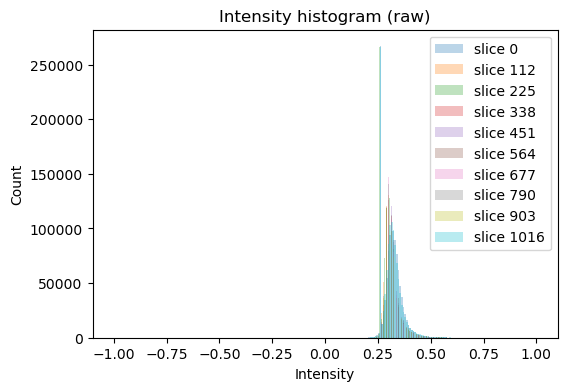

In [2]:
# Plot histogram of a few representative slices
#sample_ids = [0, stack.shape[0]//2, stack.shape[0]-1]
plt.figure(figsize=(6,4))
for i in range(10):
    plt.hist(stack[i].ravel(), bins=256, alpha=0.3, label=f"slice {indices[i]}")
plt.title("Intensity histogram (raw)")
plt.xlabel("Intensity"); plt.ylabel("Count"); plt.legend(); plt.show()


## 3) Thresholding baselines (Otsu, Li, Triangle)

We compute thresholds per-slice (local) and also a single global threshold from a representative slice (or the full stack). Compare results.

**Exercise 3.A (qualitative):** For 3–5 slices (top, middle, bottom), visualize raw image, histogram, and masks from Otsu, Li, Triangle. Discuss which one separates phases better and where each one fails (e.g., noise, low contrast, partial volume).

**Exercise 3.B (quantitative):** Compute **volume fraction** (foreground %) and **component count** per slice for each method. Plot across slices. Which method is more stable across the stack?


In [3]:
def apply_thresholds(img):
    t_otsu = threshold_otsu(img)
    t_li   = threshold_li(img,initial_guess=threshold_otsu)
    t_tri  = threshold_triangle(img)
    return (img > t_otsu), (img > t_li), (img > t_tri), (t_otsu, t_li, t_tri)

def summarize_mask(mask):
    # Volume fraction (foreground ratio) and # of connected components
    vf = mask.mean()
    # remove small holes for component count stability (optional)
    labeled = measure.label(mask, connectivity=1)
    ncc = labeled.max()
    return vf, ncc

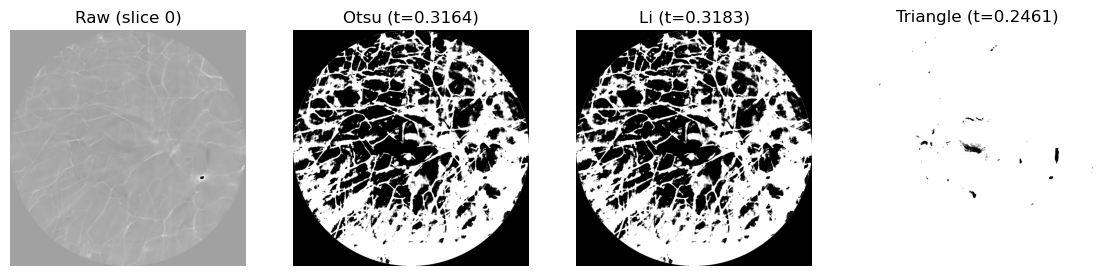

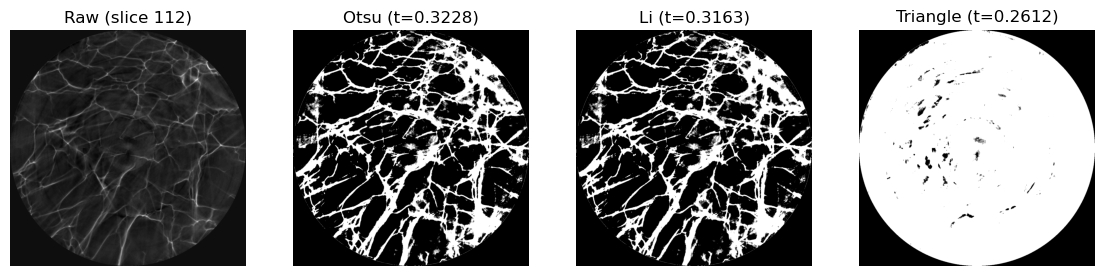

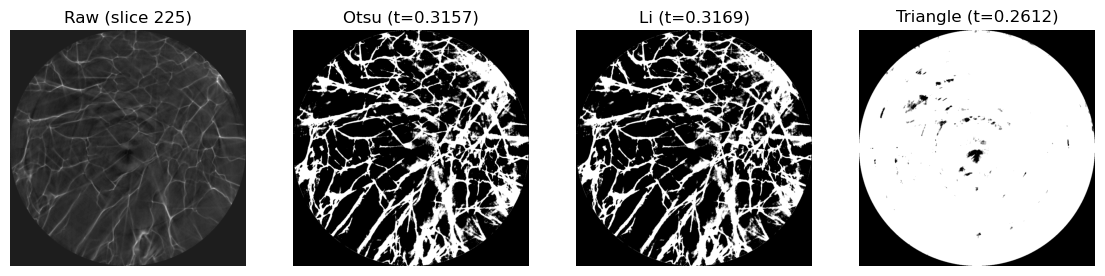

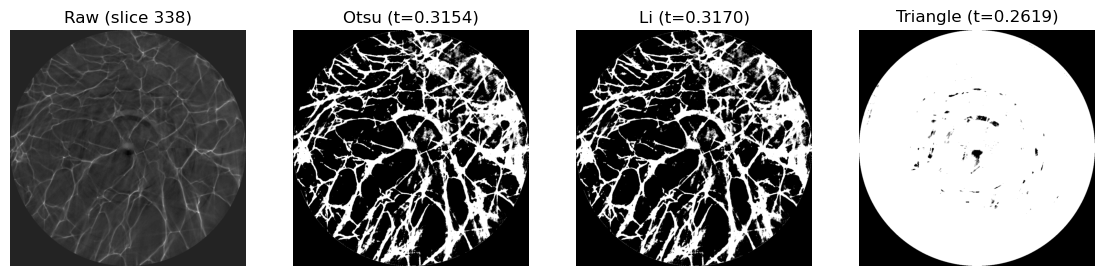

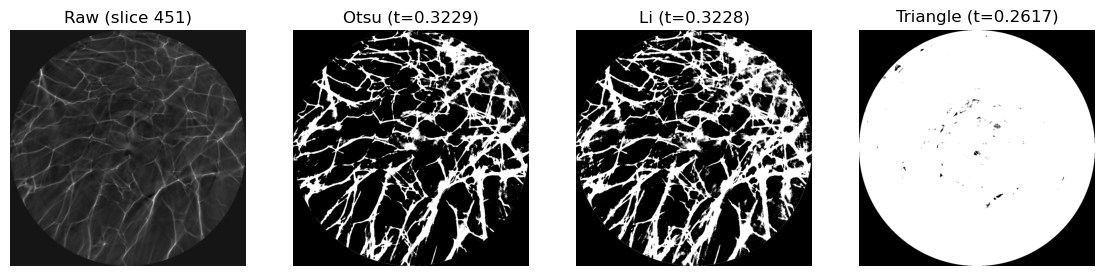

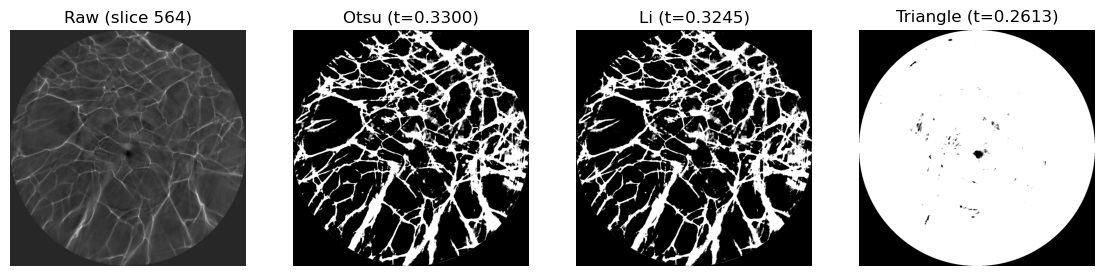

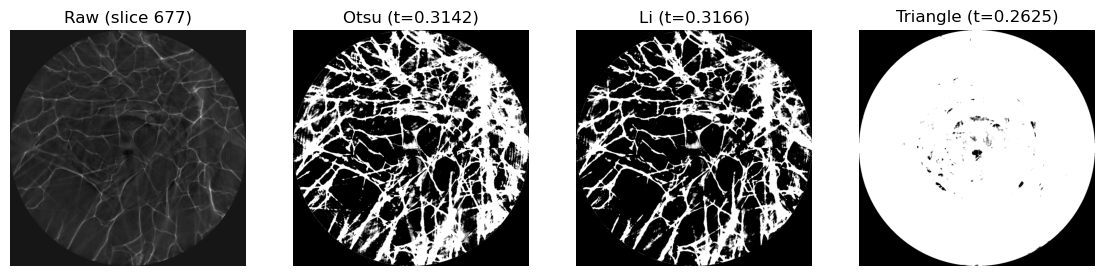

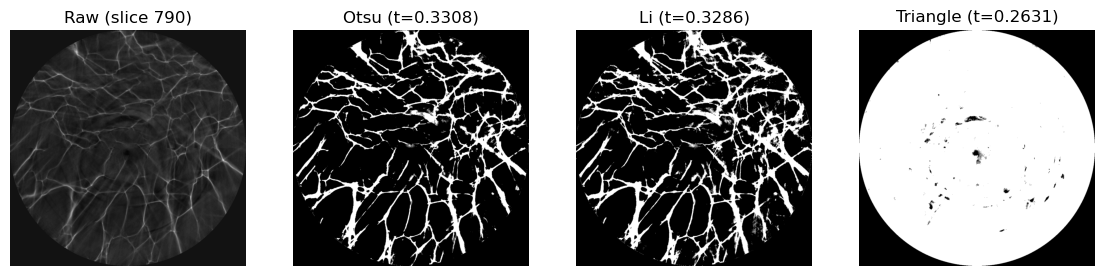

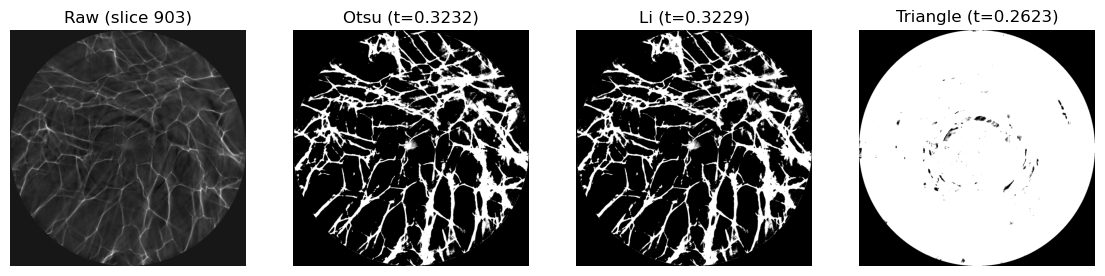

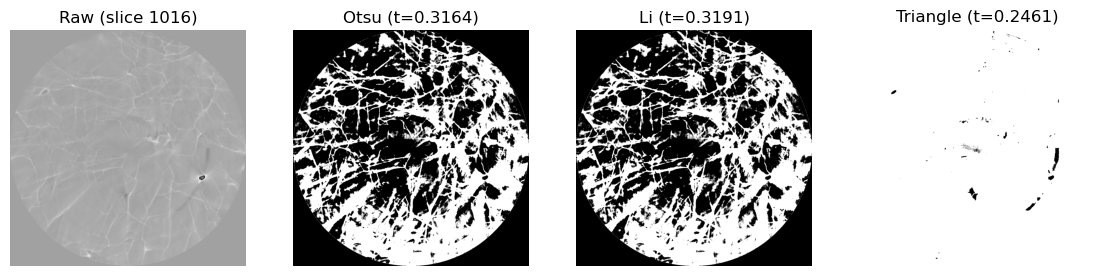

In [4]:
# Demo on a few slices
#ids = [0, stack.shape[0]//2, stack.shape[0]-1]
for i in range(MAX_SLICES):
    img = stack[i]
    m_otsu, m_li, m_tri, (t1, t2, t3) = apply_thresholds(img)

    fig, axes = plt.subplots(1,4, figsize=(14,4))
    axes[0].imshow(img, cmap="gray"); axes[0].set_title(f"Raw (slice {indices[i]})"); axes[0].axis("off")
    axes[1].imshow(m_otsu, cmap="gray"); axes[1].set_title(f"Otsu (t={t1:.4f})"); axes[1].axis("off")
    axes[2].imshow(m_li, cmap="gray"); axes[2].set_title(f"Li (t={t2:.4f})"); axes[2].axis("off")
    axes[3].imshow(m_tri, cmap="gray"); axes[3].set_title(f"Triangle (t={t3:.4f})"); axes[3].axis("off")
    plt.show()

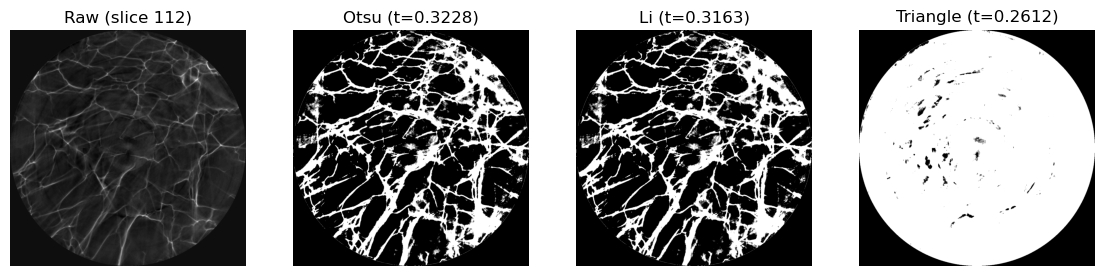

In [5]:
img = stack[1]
m_otsu, m_li, m_tri, (t1, t2, t3) = apply_thresholds(img)

fig, axes = plt.subplots(1,4, figsize=(14,4))
axes[0].imshow(img, cmap="gray"); axes[0].set_title(f"Raw (slice {indices[1]})"); axes[0].axis("off")
axes[1].imshow(m_otsu, cmap="gray"); axes[1].set_title(f"Otsu (t={t1:.4f})"); axes[1].axis("off")
axes[2].imshow(m_li, cmap="gray"); axes[2].set_title(f"Li (t={t2:.4f})"); axes[2].axis("off")
axes[3].imshow(m_tri, cmap="gray"); axes[3].set_title(f"Triangle (t={t3:.4f})"); axes[3].axis("off")
plt.show()

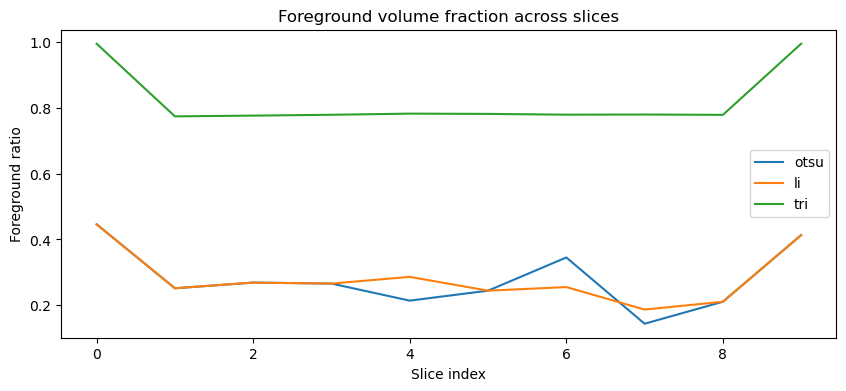

In [6]:
# Quantitative sweep across slices
methods = ["otsu", "li", "tri"]
vf_stats = {m:[] for m in methods}
ncc_stats = {m:[] for m in methods}

for img in stack:
    m_otsu, m_li, m_tri, _ = apply_thresholds(img)
    for mname, mask in zip(methods, [m_otsu, m_li, m_tri]):
        vf, ncc = summarize_mask(mask)
        vf_stats[mname].append(vf)
        ncc_stats[mname].append(ncc)

# Plot volume fraction across slices
plt.figure(figsize=(10,4))
for m in methods:
    plt.plot(vf_stats[m], label=m)
plt.title("Foreground volume fraction across slices")
plt.xlabel("Slice index"); plt.ylabel("Foreground ratio")
plt.legend(); plt.show()

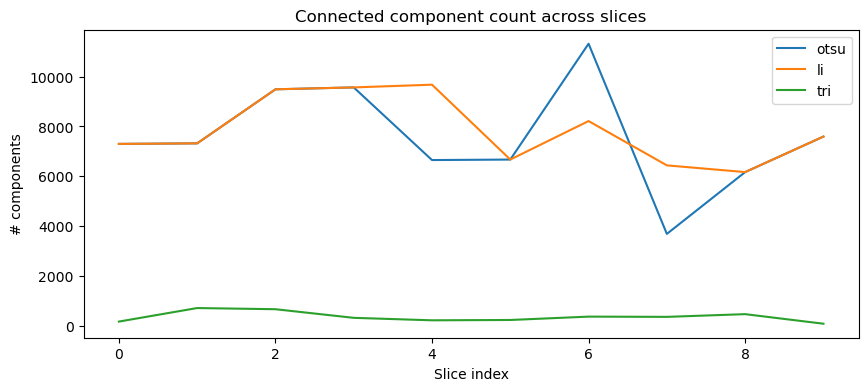

In [7]:
# Plot component count across slices
plt.figure(figsize=(10,4))
for m in methods:
    plt.plot(ncc_stats[m], label=m)
plt.title("Connected component count across slices")
plt.xlabel("Slice index"); plt.ylabel("# components")
plt.legend(); plt.show()


## 4) Speckle removal (denoising + morphology)

After thresholding, remove small speckles and spurious components.

Options:  
- **Median** or **bilateral** filtering *before* thresholding.  
- **Morphological opening/closing** *after* thresholding.  
- **`remove_small_objects`** and **`remove_small_holes`** with a size threshold in pixels.  
- **Connected component analysis** to keep only the largest structures.

**Exercise 4.A:** Choose one threshold method and compare:  
(a) no cleanup, (b) `remove_small_objects`, (c) opening+closing, (d) keep-largest-component. Quantify speckle reduction (∆component count) and effect on volume fraction.

**Tip:** Determine a reasonable `min_size` in pixels from your voxel size / expected smallest feature.


In [8]:
def clean_mask(mask, min_size=64, do_open=True, do_close=False):
    mm = mask.copy()
    if do_open:
        mm = morphology.binary_opening(mm, morphology.disk(1))
    if do_close:
        mm = morphology.binary_closing(mm, morphology.disk(1))
    mm = morphology.remove_small_objects(mm, min_size=min_size)
    mm = morphology.remove_small_holes(mm, area_threshold=min_size)
    return mm

#### Padrão

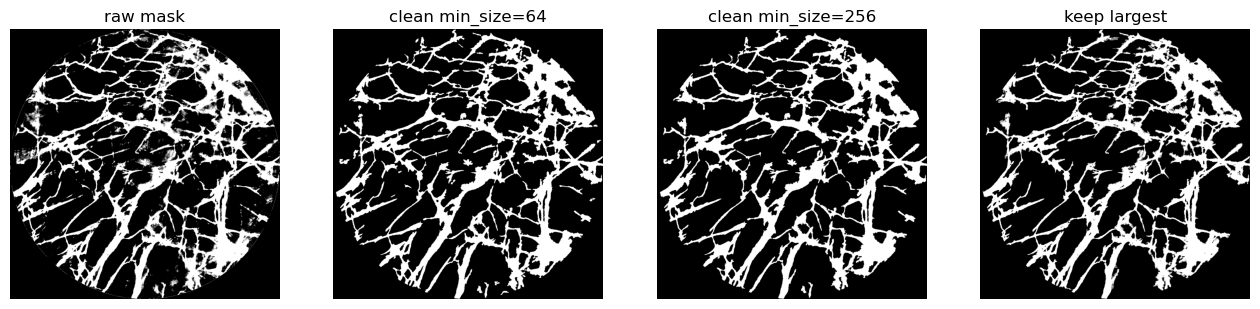

      raw_mask -> vf=0.2514, components=7323
   clean_min64 -> vf=0.2301, components=44
  clean_min256 -> vf=0.2298, components=17
  largest_only -> vf=0.2308, components=1


In [9]:
# Demonstration on a mid slice
sid = stack.shape[0]//2
img = stack[1]
m_otsu, _, _, _ = apply_thresholds(img)

variants = {
    "raw_mask": m_otsu,
    "clean_min64": clean_mask(m_otsu, min_size=64, do_open=True, do_close=False),
    "clean_min256": clean_mask(m_otsu, min_size=256, do_open=True, do_close=False),
    "largest_only": measure.label(m_otsu, connectivity=1)
}

# Keep only largest component
labels = measure.label(m_otsu, connectivity=1)
if labels.max() > 0:
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = np.argmax(counts)
    largest_only = labels == largest
else:
    largest_only = m_otsu.copy()

variants["largest_only"] = largest_only

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(variants["raw_mask"], cmap="gray"); axes[0].set_title("raw mask"); axes[0].axis("off")
axes[1].imshow(variants["clean_min64"], cmap="gray"); axes[1].set_title("clean min_size=64"); axes[1].axis("off")
axes[2].imshow(variants["clean_min256"], cmap="gray"); axes[2].set_title("clean min_size=256"); axes[2].axis("off")
axes[3].imshow(variants["largest_only"], cmap="gray"); axes[3].set_title("keep largest"); axes[3].axis("off")
plt.show()

# Quantify delta in component count
for name, m in variants.items():
    vf, ncc = summarize_mask(m)
    print(f"{name:>14} -> vf={vf:.4f}, components={ncc}")

#### Threshold Li

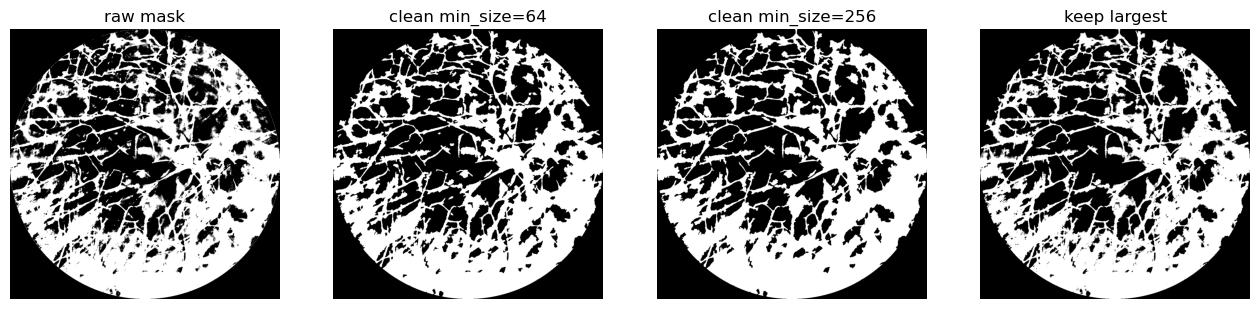

      raw_mask -> vf=0.4459, components=7301
   clean_min64 -> vf=0.4263, components=29
  clean_min256 -> vf=0.4320, components=11
  largest_only -> vf=0.4295, components=1


In [10]:
# Demonstration on a mid slice
sid = stack.shape[0]//2
img = stack[0]
_, m_li, _, _ = apply_thresholds(img)

variants = {
    "raw_mask": m_li,
    "clean_min64": clean_mask(m_li, min_size=64, do_open=True, do_close=False),
    "clean_min256": clean_mask(m_li, min_size=256, do_open=True, do_close=False),
    "largest_only": measure.label(m_li, connectivity=1)
}

# Keep only largest component
labels = measure.label(m_li, connectivity=1)
if labels.max() > 0:
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = np.argmax(counts)
    largest_only = labels == largest
else:
    largest_only = m_li.copy()

variants["largest_only"] = largest_only

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(variants["raw_mask"], cmap="gray"); axes[0].set_title("raw mask"); axes[0].axis("off")
axes[1].imshow(variants["clean_min64"], cmap="gray"); axes[1].set_title("clean min_size=64"); axes[1].axis("off")
axes[2].imshow(variants["clean_min256"], cmap="gray"); axes[2].set_title("clean min_size=256"); axes[2].axis("off")
axes[3].imshow(variants["largest_only"], cmap="gray"); axes[3].set_title("keep largest"); axes[3].axis("off")
plt.show()

# Quantify delta in component count
for name, m in variants.items():
    vf, ncc = summarize_mask(m)
    print(f"{name:>14} -> vf={vf:.4f}, components={ncc}")


#### do_open=False, do_close=True

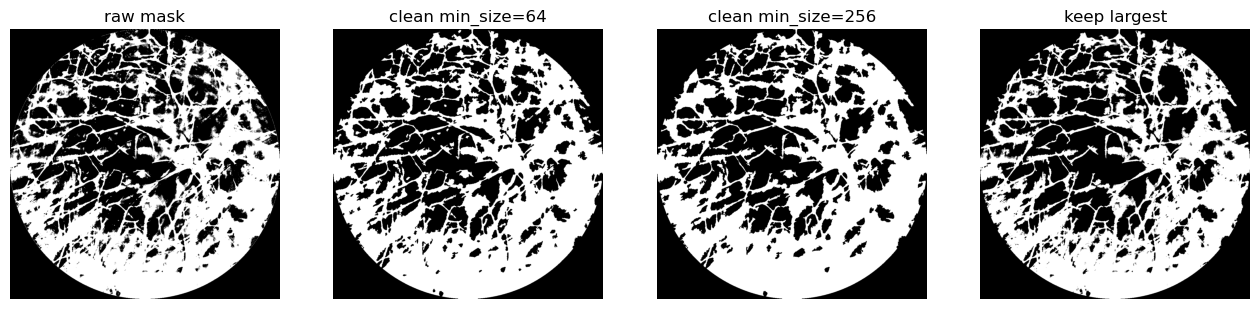

      raw_mask -> vf=0.4459, components=7301
   clean_min64 -> vf=0.4677, components=26
  clean_min256 -> vf=0.4749, components=3
  largest_only -> vf=0.4295, components=1


In [11]:
# Demonstration on a mid slice
sid = stack.shape[0]//2
img = stack[0]
m_otsu, _, _, _ = apply_thresholds(img)

variants = {
    "raw_mask": m_otsu,
    "clean_min64": clean_mask(m_otsu, min_size=64, do_open=False, do_close=True),
    "clean_min256": clean_mask(m_otsu, min_size=256, do_open=False, do_close=True),
    "largest_only": measure.label(m_otsu, connectivity=1)
}

# Keep only largest component
labels = measure.label(m_otsu, connectivity=1)
if labels.max() > 0:
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = np.argmax(counts)
    largest_only = labels == largest
else:
    largest_only = m_otsu.copy()

variants["largest_only"] = largest_only

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(variants["raw_mask"], cmap="gray"); axes[0].set_title("raw mask"); axes[0].axis("off")
axes[1].imshow(variants["clean_min64"], cmap="gray"); axes[1].set_title("clean min_size=64"); axes[1].axis("off")
axes[2].imshow(variants["clean_min256"], cmap="gray"); axes[2].set_title("clean min_size=256"); axes[2].axis("off")
axes[3].imshow(variants["largest_only"], cmap="gray"); axes[3].set_title("keep largest"); axes[3].axis("off")
plt.show()

# Quantify delta in component count
for name, m in variants.items():
    vf, ncc = summarize_mask(m)
    print(f"{name:>14} -> vf={vf:.4f}, components={ncc}")

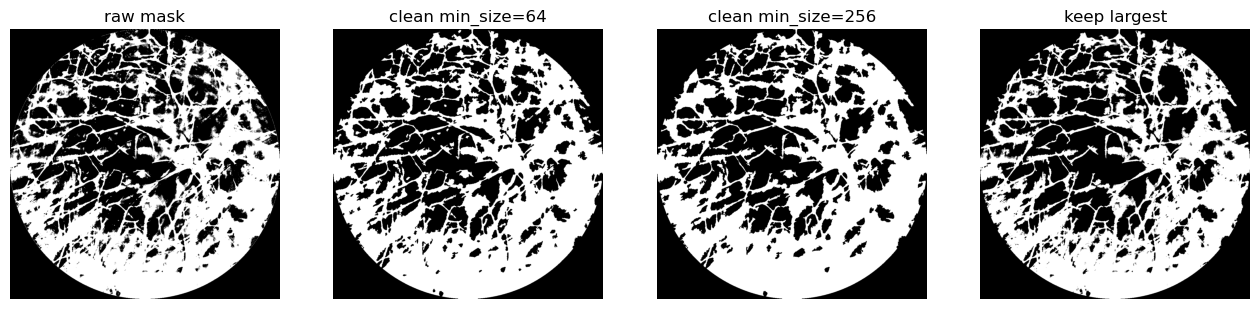

      raw_mask -> vf=0.4459, components=7301
   clean_min64 -> vf=0.4677, components=26
  clean_min256 -> vf=0.4749, components=3
  largest_only -> vf=0.4295, components=1


In [12]:
def clean_mask2(mask, min_size=64, do_open=True, do_close=False):
    mm = mask.copy()
    if do_open:
        mm = morphology.binary_opening(mm, morphology.disk(20))
    if do_close:
        mm = morphology.binary_closing(mm, morphology.disk(20))
    mm = morphology.remove_small_objects(mm, min_size=min_size)
    mm = morphology.remove_small_holes(mm, area_threshold=min_size)
    return mm

# Demonstration on a mid slice
sid = stack.shape[0]//2
img = stack[0]
m_otsu, _, _, _ = apply_thresholds(img)

variants = {
    "raw_mask": m_otsu,
    "clean_min64": clean_mask(m_otsu, min_size=64, do_open=False, do_close=True),
    "clean_min256": clean_mask(m_otsu, min_size=256, do_open=False, do_close=True),
    "largest_only": measure.label(m_otsu, connectivity=1)
}

# Keep only largest component
labels = measure.label(m_otsu, connectivity=1)
if labels.max() > 0:
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = np.argmax(counts)
    largest_only = labels == largest
else:
    largest_only = m_otsu.copy()

variants["largest_only"] = largest_only

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(variants["raw_mask"], cmap="gray"); axes[0].set_title("raw mask"); axes[0].axis("off")
axes[1].imshow(variants["clean_min64"], cmap="gray"); axes[1].set_title("clean min_size=64"); axes[1].axis("off")
axes[2].imshow(variants["clean_min256"], cmap="gray"); axes[2].set_title("clean min_size=256"); axes[2].axis("off")
axes[3].imshow(variants["largest_only"], cmap="gray"); axes[3].set_title("keep largest"); axes[3].axis("off")
plt.show()

# Quantify delta in component count
for name, m in variants.items():
    vf, ncc = summarize_mask(m)
    print(f"{name:>14} -> vf={vf:.4f}, components={ncc}")


## 5) Watershed with markers

Watershed can split touching structures if you provide reasonable markers. A common recipe:
1) Smooth (Gaussian/median).  
2) Threshold (e.g., Otsu) to get a coarse foreground.  
3) Compute **distance transform** inside the foreground.  
4) Find **local maxima** as markers (tune `min_distance` or use `h-minima`).  
5) Run `segmentation.watershed` on the inverted distance (or gradients).

**Exercise 5.A:** Tune the marker detection to avoid over/under‑segmentation. Compare the number/size distribution of segments vs. raw thresholding.


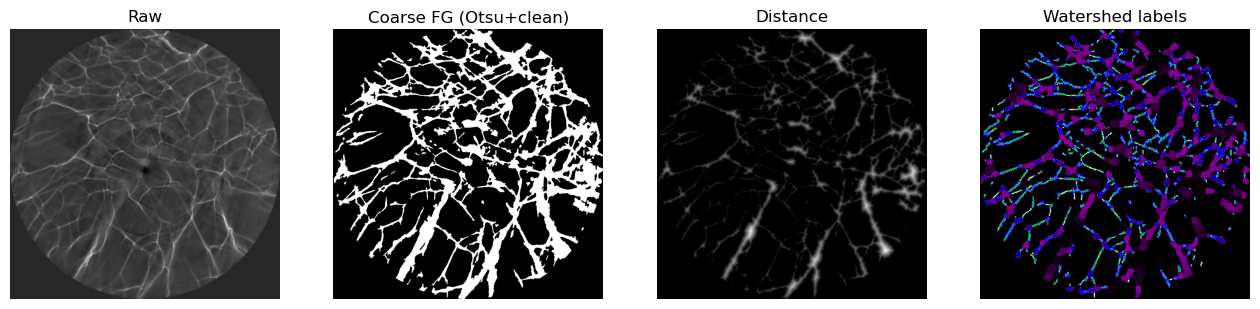

Watershed regions: 2428


In [13]:

from skimage.feature import peak_local_max

sid = stack.shape[0]//2
img = stack[sid]

# 1) Smooth
img_s = ndi.median_filter(img, size=3)

# 2) Coarse foreground via Otsu
mask = img_s > threshold_otsu(img_s)
mask = clean_mask(mask, min_size=64, do_open=True, do_close=False)

# 3) Distance transform (inside foreground)
dist = ndi.distance_transform_edt(mask)

# 4) Markers from local maxima (tune min_distance)
coords = peak_local_max(dist, footprint=np.ones((9,9)), labels=mask)
markers = np.zeros_like(dist, dtype=int)
for i, (r,c) in enumerate(coords, start=1):
    markers[r, c] = i

# Alternative: use h-minima to suppress shallow peaks
# dist_h = morphology.h_minima(-dist, h=1.0)  # on inverted dist; adjust h
# markers, _ = ndi.label(~dist_h & mask)

# 5) Watershed (on inverted distance)
labels_ws = segmentation.watershed(-dist, markers, mask=mask)

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(img, cmap="gray"); axes[0].set_title("Raw"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Coarse FG (Otsu+clean)"); axes[1].axis("off")
axes[2].imshow(dist, cmap="gray"); axes[2].set_title("Distance"); axes[2].axis("off")
axes[3].imshow(labels_ws, cmap="nipy_spectral"); axes[3].set_title("Watershed labels"); axes[3].axis("off")
plt.show()

props = measure.regionprops_table(labels_ws, properties=("label","area","eccentricity"))
print("Watershed regions:", len(props["label"]))



## 6) Batch segmentation + simple QC

Run your preferred pipeline across slices and compute simple QC metrics to decide which slices are **good enough** to keep as training targets later (e.g., stable volume fraction, plausible component sizes).

**Exercise 6.A:** Implement a batch function that:  
- Applies (method + cleanup),  
- Measures volume fraction and component count,  
- Saves masks to `masks/<method>/slice_xxxx.png`.

Then, plot distributions and flag outliers (e.g., slices with volume fraction far from the median).


In [14]:

import pandas as pd
from tqdm import tqdm
import imageio.v2 as imageio

OUT_DIR = Path("./masks")
OUT_DIR.mkdir(exist_ok=True)

def segment_slice(img, method="otsu", min_size=128):
    if method == "otsu":
        mask = img > threshold_otsu(img)
    elif method == "li":
        mask = img > threshold_li(img,initial_guess=threshold_otsu)
    elif method == "tri":
        mask = img > threshold_triangle(img)
    else:
        raise ValueError("method must be one of: 'otsu', 'li', 'tri'")
    mask = clean_mask(mask, min_size=min_size, do_open=True, do_close=False)
    return mask

def batch_segment(stack, method="otsu", min_size=128, save=True):
    mdir = OUT_DIR / method
    if save:
        mdir.mkdir(parents=True, exist_ok=True)
    records = []
    for i in tqdm(range(stack.shape[0])):
        img = stack[i]
        mask = segment_slice(img, method=method, min_size=min_size)
        vf, ncc = summarize_mask(mask)
        if save:
            imageio.imwrite(mdir / f"slice_{i:04d}.png", (mask*255).astype(np.uint8))
        records.append({"slice": i, "method": method, "vf": vf, "ncc": ncc})
    return pd.DataFrame(records)

df_otsu = batch_segment(stack, method="otsu", min_size=128, save=False)
df_li   = batch_segment(stack, method="li",   min_size=128, save=False)
df_tri  = batch_segment(stack, method="tri",  min_size=128, save=False)

df = pd.concat([df_otsu, df_li, df_tri], ignore_index=True)
df.head()


100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


slice method        vf  ncc
0      0   otsu  0.428547   18
1      1   otsu  0.230336   27
2      2   otsu  0.243811   14
3      3   otsu  0.239726   19
4      4   otsu  0.194498   19

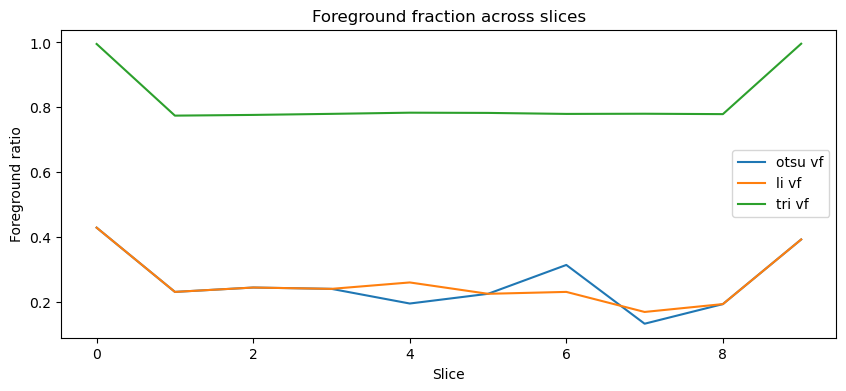

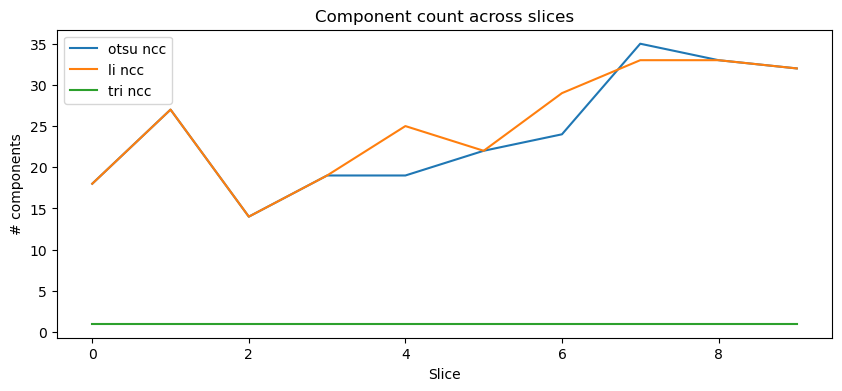

Potential outliers (|z|>3):


Empty DataFrame
Columns: [slice, method, vf, ncc, vf_z]
Index: []

In [15]:
# Plot per-method distributions
plt.figure(figsize=(10,4))
for m in df["method"].unique():
    d = df[df["method"] == m]
    plt.plot(d["slice"], d["vf"], label=f"{m} vf")
plt.title("Foreground fraction across slices")
plt.xlabel("Slice"); plt.ylabel("Foreground ratio"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
for m in df["method"].unique():
    d = df[df["method"] == m]
    plt.plot(d["slice"], d["ncc"], label=f"{m} ncc")
plt.title("Component count across slices")
plt.xlabel("Slice"); plt.ylabel("# components"); plt.legend(); plt.show()

# Flag outliers by z-score on vf per method
def zscore(x): 
    return (x - x.mean()) / (x.std() + 1e-8)

df["vf_z"] = df.groupby("method")["vf"].transform(zscore)
outliers = df[np.abs(df["vf_z"]) > 3]
print("Potential outliers (|z|>3):")
outliers.head(10)



## 7) Manual curation (for deep learning seed set)

Pick ~20–50 slices covering different structures/contrast conditions. For each:
1) Start from your **best** automatic mask.  
2) Manually refine it removing speckles
3) Save final masks to `gold_masks/` with the same filename pattern.

**Exercise 7.A:** Create `gold_masks/` and export at least **20** curated masks. Keep a CSV with columns: `slice, method, notes` describing any manual edits. This metadata is valuable for the next step.



## 8) Report checklist (turn in with your notebook)

- [ ] Describe your chosen pipeline (method + cleanup) and why.  
- [ ] Plots of volume fraction and component count across slices, with outliers marked.  
- [ ] One qualitative panel comparing Otsu/Li/Triangle on representative slices.  
- [ ] Watershed example with markers and a short discussion of tuning.  
- [ ] At least 20 curated `gold_masks/`
- [ ] Brief reflection: *What failure modes did you see?* *What would you try next if you had more time?*



## (Optional) 3D quick look

If memory allows, assemble a 3D volume and visualize one binary mask in 3D (e.g., with `skimage.measure.marching_cubes` or napari). This is helpful to spot systemic issues not obvious slice‑wise.


In [16]:

# Optional 3D look (may be memory-intensive)
# Build a binary volume from your preferred method on a subset of slices
subset = stack[::5]   # every 5th slice to reduce size
vol_mask = subset > threshold_otsu(subset)  # quick demo; consider your final pipeline
print("vol_mask shape:", vol_mask.shape)

# Surface extraction (iso-surface on 3D binary)
from skimage import measure as skmeasure
try:
    verts, faces, normals, values = skmeasure.marching_cubes(vol_mask.astype(float), level=0.5)
    print("Surface vertices:", verts.shape[0], "faces:", faces.shape[0])
except Exception as e:
    print("3D surface extraction skipped:", e)


vol_mask shape: (2, 1100, 1100)
Surface vertices: 743339 faces: 1210950
